### TODO
0. For Feature Selection, we fit only on X and it fits only on Train Data - The scoring functions are however based on Time Series CV splits (which first fits the data on Train indices and then scores on Test Indices)
1. sample_weights - If we want to use strategy P&L as score, we can't assign maximum weights to "0" values in sample_weights
2. Outlier Detection & removal
3. Imputation
4. Create Score function - P&L - Based on Long Short position, position size and % return
5. Rectify Class Imbalance 
6. F1_score weighted looks odd - even when both precision_weighted and recall_weighted is lower, f1_weighed is higher?
7. Check each number in features_df!
8. If we put returns as Sample weights, he model will ignore all rows where returns equals 0 and that class will be under represented - Look at class_weight and sample_weight - However, if we do # 1, then sample_weights no longer reflect P&L and we want our score function to represent that


** Not able to pass sample_weight to transformation fit function

**autoreload script**

In [1]:
# %reload_ext autoreload
# %autoreload 2

# import _model_build_func
# import importlib
# importlib.reload(_model_build_func)
# from _model_build_func import *

**Functions List**
1. metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))  - return df          
2. predictions_from_custom_cross_val(model,X, y, custom_cv = BlockingTimeSeriesSplit(n_splits=5), sampled_weights=False) - returns original, predicted
3. probabilities_from_custom_cross_val(model,X, y, custom_cv = BlockingTimeSeriesSplit(n_splits=5), sampled_weights=False) - returns original, predicted_proba


In [2]:
# Takes 2.10 minutes to run
import warnings
warnings.filterwarnings('ignore')
from support._model_build_func import *


Getting data from CWP database & excel files::  33%|███▎      | 1/3 [00:03<00:07,  3.99s/it]

Time Taken for Contract:1 00:03


Getting data from CWP database & excel files::  67%|██████▋   | 2/3 [00:07<00:03,  3.47s/it]

Time Taken for Contract:2 00:07


Getting data from CWP database & excel files:: 100%|██████████| 3/3 [00:10<00:00,  3.43s/it]

Time Taken for Contract:3 00:10


### Steps in Getting Processed Data

1. Get Raw data from Excel
2. Imputing Values for missing values - Backfilling and then frontfilling Variables DataFrame, and filling zeros with Median? - Check if it makes sense
3. Adding Date Features
4. Adding Technical Indicator Features
5. Replacing punctuation strings in column names
6. Finding Last Available Date for each column
7. For now using custom based method - but change it eventually with KNN (or Multivariate) Imputation etc.- # Takes 35 secounds to run
8. Remove Variables with all NaNs
9. Change Bool cols (mostly date columns such as Is_year_end etc.) to int columns
10. Winsorzing/Capping ['Adj_ret_2', 'Close_ret'] - **Instead of capping Adj_ret_2/Close_ret - try to figure out why we see abnormal returns such as -40% and +27%**

In [3]:
Variables = Variables_.copy(deep=True)
Response = Response_.copy(deep=True)
Variables_midx = Variables_midx_.copy(deep=True)
last_valid_loc = last_valid_loc_.copy(deep=True)
Variables_with_nans = Variables_with_nans_

len(Variables), len(Response), Variables.shape, Response.shape

(2665, 2665, (2665, 783), (2665, 10))

### MultiClassification Targets - Choose between 3 or 5 classes

Labels
 0        932
 1        886
-1        847
dtype: int64


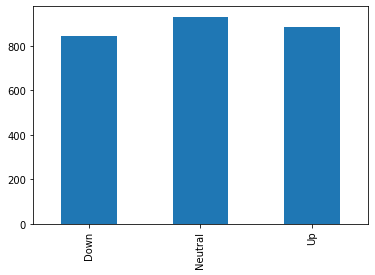

In [4]:
pv_1 = 0.0025 # higher and lower than 0.25% return
pv_2 = 0.0075 # higher and lower than 1% return
col = 'Adj_ret_2' # Can also be 'Close_ret'

num_classes = 3 # Choose 3 or 5
Response = get_multiclass_labels(num_classes,pv_1,pv_2, Response,col)

Labels
 0        932
 1        886
-1        847
dtype: int64


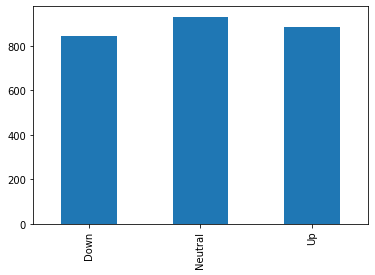

In [5]:
pv_1 = 0.0025 # higher and lower than 0.25% return
pv_2 = 0.0075 # higher and lower than 1% return
col = 'Adj_ret_2' # Can also be 'Close_ret'

num_classes = 3 # Choose 3 or 5
Response = get_multiclass_labels(num_classes,pv_1,pv_2, Response,col)

### Splitting the Dataset in 3 Dictionaries of Training, Testing & Validation & Initiating features_df

###### Note: If metric calculations in add_metric function is calculated on Data which has even one class missing from y_predictions, it will throw an error (when error='raise' used), or it will be NaN for (roc_auc_ovr_weighted & roc_auc_ovo_weighted) if this option is not used in cross_val_score..


In [6]:
X_train_dict, X_test_dict, X_val_dict, y_train, y_test, y_val, sample_weights_train, sample_weights_test, sample_weights_val \
    = ttv_split(Variables, Response, test_size=0.50, Validation_date_start = '2022-01-01')

In [7]:
last_valid_loc[last_valid_loc.isna().any(axis=1)]

End_Dt
Lumber_Track_north_american_production Prairies_And_Eastern_Canada              NaT
                                       Total_North_America                      NaT
Lumber_Track_north_american_shipment   Prairies_And_Eastern_Canada              NaT
                                       Total_North_America                      NaT
CFTC_legacy                            Total_Reportable_Positions_Long_All      NaT
                                       Concentration_Gross_LT_4_TDR_Short_Ol    NaT

<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why these variables have NaNs
</div>


In [8]:
len(Variables_with_nans)

84

In [9]:
Variables_with_nans

{('CFTC_legacy', 'Concentration_Gross_LT_4_TDR_Short_Ol'),
 ('CFTC_legacy', 'Total_Reportable_Positions_Long_All'),
 ('Date_', 'CFTC_disaggregated'),
 ('Date_', 'CFTC_legacy'),
 ('Date_', 'CP_Terminal_Dwell'),
 ('Date_', 'CP_Train_Speed'),
 ('Date_', 'Canada Rail Lumber & Wood Prods'),
 ('Date_', 'Canadian_National_Railway'),
 ('Date_', 'Canadian_Pacific'),
 ('Date_', 'Construction Spending'),
 ('Date_', 'FEA_Lumber_Advisor_value'),
 ('Date_', 'FRED_Daily'),
 ('Date_', 'FRED_Daily, 7-Day'),
 ('Date_', 'FRED_Daily, Close'),
 ('Date_', 'FRED_Monthly'),
 ('Date_', 'FRED_Quarterly'),
 ('Date_', 'FRED_Weekly, As of Wednesday'),
 ('Date_', 'FRED_Weekly, Ending Monday'),
 ('Date_', 'FRED_Weekly, Ending Saturday'),
 ('Date_', 'FRED_Weekly, Ending Thursday'),
 ('Date_', 'FRED_Weekly, Ending Wednesday'),
 ('Date_', 'FTR'),
 ('Date_', 'GSCPI'),
 ('Date_', 'Investingdotcom'),
 ('Date_', 'Lumber_Adjusted_dfs'),
 ('Date_', 'Lumber_Contract_Spreads'),
 ('Date_', 'Lumber_OHLCV'),
 ('Date_', 'Lumber_Tr

In [10]:
print("Variable Types")
print(pd.Series(Variables.dtypes.values).value_counts())
print("Total Variables:",pd.Series(Variables.dtypes.values).value_counts().sum())

print('\n')
print("Response Types")
print(pd.Series(Response.dtypes.values).value_counts())


Variable Types
float64    764
int64       10
int32        7
object       2
dtype: int64
Total Variables: 783


Response Types
float64    10
int32       1
dtype: int64


### Sample weights - Removed Outliers from Response by replacing with IQR*1.5 upper and lower limits

In [11]:
col = 'Adj_ret_2'
create_bins_data(Response, col, 10)

Max: 0.1024453116726735
Min: -0.1387440497997851


(-0.14, -0.112]         0.11
(-0.112, -0.0851]       0.00
(-0.0851, -0.0583]      0.90
(-0.0583, -0.0315]      4.62
(-0.0315, -0.00475]    31.52
(-0.00475, 0.022]      47.95
(0.022, 0.0488]        13.10
(0.0488, 0.0756]        1.61
(0.0756, 0.102]         0.19
Name: Adj_ret_2, dtype: float64

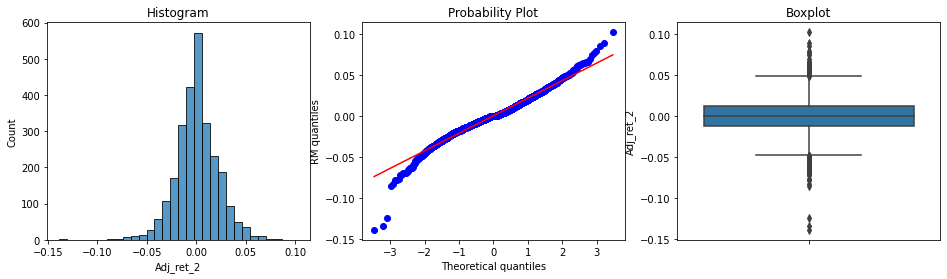

In [12]:
diagnostic_plots(Response, col)

In [13]:
# print(winsoriser.left_tail_caps_)
# print(winsoriser.right_tail_caps_)

print(Response[['Labels','sample_weights']].groupby('Labels').sum())
print(Response[['Labels','sample_weights']].groupby('Labels').mean())

        sample_weights
Labels                
-1          865.544398
 0          934.890245
 1          906.603256
        sample_weights
Labels                
-1            1.021894
 0            1.003101
 1            1.023254


In [14]:
create_bins_data(Response, 'sample_weights', 10)

Max: 1.1387440497997852
Min: 1.0


(0.999, 1.015]    59.21
(1.015, 1.031]    27.20
(1.031, 1.046]     9.12
(1.046, 1.062]     2.81
(1.062, 1.077]     1.20
(1.077, 1.092]     0.30
(1.092, 1.108]     0.04
(1.108, 1.123]     0.00
(1.123, 1.139]     0.11
Name: sample_weights, dtype: float64

### EVALUATION METRICS & generate_sample_confusion_matrix
    1. Recall/Sensitivity/TPR: tp / (tp + fn) - **%age of a TRUE/Positives class correctly identified/ ability to find all the positive samples**. This deciedes how many times we trade since its the propotion of actual positives we are able to detect.
    2. Specificity (TNR) is tn / (tn + fp) - %age of a FALSE/Negatives class correctly identified
    3. False Positive Rate (FPR) = 1 - Specificity or fp / (tn + fp). 
    4. Accuracy is TP/ entire matrix sum ???
    5. Precision is tp / (tp + fp) - the ability not to label a negative sample as positive. This deciedes our PROFITABILITY since we don't want FALSE Positives
    6. Support is the number of occurrences of each class  - sum of respective row
    7. Macro - unweighted mean. This does not take label imbalance into account.
    8. Wt_Avg - average weighted by support
    9. Micro - same as accuracy - sum of diagnols/ sum of all matrix

**True/False (Positives/Negatives) means if a sample belongs/doesn't belong to a class**


In [15]:
lab = Response.Labels.unique()
lab.sort()

generate_sample_confusion_matrix(1,lab)

### Blocked Time Series cross-validation
https://goldinlocks.github.io/Time-Series-Cross-Validation/

In [16]:
btscv = BlockingTimeSeriesSplit(n_splits=5)

**Metrics from Confusion Matrix Custom Func - These metrics (weighted & average) do NOT exactly match the output of features_df metrics** 
** Also note that the weighted average results are not based on sample_weights for now

In [17]:
# RAJA 

# X = pd.concat([X_train_dict['Original'], X_test_dict['Original']], axis=0)
# y = pd.concat([y_train, y_test], axis=0)
# X.shape, y.shape
# model = models[0]
# train_idx  = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = False)['train']
# test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = False)['test']

# # Issue with shape - need to correct 
# predicted_proba1 = []
# for i in range(len(train_idx)):
#     model.fit(X.iloc[train_idx[i]], y.Labels.iloc[train_idx[i]])
#     predicted_proba1.append(model.predict_proba(X.iloc[test_idx[i]]))

### Helper Functions

In [18]:
# This func is only to initialize the X variables with some features set - typically, we use 'Original' if not passed in
def fill_with_dataset(dataset,manual_list, original_dataset = 'Original'):
    if manual_list:
        X_train_dict[dataset] = X_train_dict[original_dataset][manual_list]
        X_test_dict[dataset] = X_test_dict[original_dataset][manual_list]
        X_val_dict[dataset] = X_val_dict[original_dataset][manual_list]
        
    else:
        X_train_dict[dataset] = X_train_dict[original_dataset]
        X_test_dict[dataset] = X_test_dict[original_dataset]
        X_val_dict[dataset] = X_val_dict[original_dataset]

In [19]:
# this func first fits the transformation to all indices of X_train from cv (btscv), then transforms the features from X_train, X_test and X_val
# For each pipeline trasnformation, we are using same sample_weights_train - Not working
def transform_features_space(dataset,pipe,sampled_weights=False):
    print("\nRemoving Features for dataset:",dataset)
    print("# Features before:",len(X_train_dict[dataset].columns.to_list()))
    

    X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test,set='combined')
    train_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['train']
    
    # Since this is not working sampled_weights True is same as False
    if sampled_weights:

        # NOT WORKING
        # parameters = {pipe.steps[i][0] + "__sample_weight": y.iloc[train_idx].sample_weights.values for i in range(len(pipe.steps))}
        # pipe.fit(X.iloc[train_idx], **parameters)
        pipe.fit(X.iloc[train_idx])
    else:
        pipe.fit(X.iloc[train_idx])
        
    X_train_dict[dataset] = pipe.transform(X_train_dict[dataset])
    X_test_dict[dataset] = pipe.transform(X_test_dict[dataset])
    X_val_dict[dataset] = pipe.transform(X_val_dict[dataset])

In [20]:
#
# BAJA


# len(features_df.drop(['Model_Details','Features_List'],axis=1).loc[('RandomForestClassifier','ManualSelection_Weighted_Transformed')]['Removed_Features'])

In [21]:
def add_to_features_df(model,dataset):
    model_name = type(model).__name__
    features_df.loc[(model_name, dataset),'Num_Features'] = len(X_train_dict[dataset].columns) # so can store list of features
    features_df.loc[(model_name, dataset),'Features_List'] = X_train_dict[dataset].columns.to_list()

    original_list = set(features_df.loc[(model_name, 'Original'),'Features_List'])
    dataset_list = set(features_df.loc[(model_name, dataset),'Features_List'])
    removed_list = list(sorted(original_list - dataset_list))
    
    features_df.loc[(model_name, dataset),'Removed_Features'] = removed_list
    features_df.loc[(model_name, dataset),'Model_Details'] = model

def get_shapes(dataset):
    # print("\nShapes for dataset:",dataset)
    print("X_train Shape",X_train_dict[dataset].shape)
    print("X_test Shape",X_test_dict[dataset].shape)
    print("X_val Shape",X_val_dict[dataset].shape)
    # print("y_train Shape",y_train.shape)
    # print("y_test Shape",y_test.shape)
    # print("y_val Shape",y_val.shape)

def print_pipe_removed(pipe):
    total_removed = 0
    # print("\nRemoved Features for Pipeline:",pipe)
    for i in range(len(pipe.steps)):
        step_name = pipe.steps[i][0]
        total_removed += len(pipe.named_steps[step_name].features_to_drop_)
        print(step_name, ":",len(pipe.named_steps[step_name].features_to_drop_))
    print("Total removed:",total_removed)

# Calls all the above 3 functions
def insert_and_print(model,dataset,pipe, manual_list):
    print("\nInserting Pipeline for dataset:",dataset)

    # This code INSERTS model's basic data into features_df
    add_to_features_df(model,dataset)

    # This code PRINTS X variables Shape
    get_shapes(dataset)

    # This code prints the features removed for each pipe step
    if not manual_list: print_pipe_removed(pipe)
  


In [22]:
# Response['Labels'].unique()
lab

array([-1,  0,  1])


*****Change between Labels & Close_Up_Down columns for y_combined to make it either a Multiclass (5) or (3)***

In [23]:
# **cross_val_score - accuracy_score**                                                      
# scoring https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

def add_metrics(model,dataset,X_train_dict,X_test_dict,y_train,y_test,set='combined', sampled_weights=False):

    model_name = type(model).__name__
    metrics_list = ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted','neg_log_loss']

    # Using BlockedTimeSeriesSplit cross val to calculate metrics
    X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')

    for metric in metrics_list:

        if sampled_weights:
        # cross_val_score with SAMPLE_WEIGHTS
            score = cross_val_score(model, X, y.Labels, cv=btscv, scoring = str(metric),fit_params={'sample_weight':y.sample_weights.values}) #,error_score="raise"
        else:
            score = cross_val_score(model, X, y.Labels, cv=btscv, scoring = str(metric)) #,error_score="raise"
            
        features_df.loc[(model_name, dataset),metric]= round(np.mean(score),2)

    # Calculating Class Wise Metrics - although predictions_from_custom_cross_val uses sample_weights to fit & predict but the metrics_from_cm doesn't use sample_weights
    original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=sampled_weights)
    cm = pd.DataFrame(confusion_matrix(original, predicted), index=Response['Labels'].unique(), columns=Response['Labels'].unique())
    all_class_metric = metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))

    # Calculating pnl_score & sharpe - Adj_ret_2 is Log Returns so can simply add them after multiplying with predictions
    Test_adj_returns = y.Adj_ret_2.iloc[get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5)['test']].values.tolist()
    return_list = [a*b for a,b in zip(Test_adj_returns,predicted)]
    return_std = np.std(return_list)
    pnl_score = np.sum(return_list)
    sharpe_ratio = (pnl_score - 0.0)/return_std
    features_df.loc[(model_name, dataset),'pnl'] = pnl_score
    features_df.loc[(model_name, dataset),'sharpe'] = sharpe_ratio * np.sqrt(252) # Annualized


    # Calculating Kappa Score 
    if sampled_weights:
    # Kappa with SAMPLE_WEIGHTS
        sample_weights = y.sample_weights.iloc[get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5)['test']].values.tolist()
        kappa_score = cohen_kappa_score(original, predicted, sample_weight=sample_weights)
    else:
        kappa_score = cohen_kappa_score(original, predicted)
    
    features_df.loc[(model_name, dataset),'Kappa']= kappa_score
    
    # Insert the dataframe in a cell in features_df
    features_df.loc[(model_name, dataset),'ClassDf'] = np.array([])
    features_df.loc[(model_name, dataset),'ClassDf'].astype(object)
    features_df.loc[(model_name, dataset),'ClassDf'] =  [all_class_metric]
        

### Model Transformation Func

###### NOTE THE MODEL PIPELINES ARE BEING CHECKED/FITTED TO TRAINING DATA WHILE THE METRICS ARE calculated ON Set option in func argument

In [24]:
# This function does the following steps:
# 1. Fill the dataset with passed X Variables
# 2. If transform = True is passed, it fits and transforms the X variable. If sampled_weights equals True, it provides test sample weights to the fitting transformation
# 3. Inserts model's basic data (length of features etc) into features_df, PRINTS X variables Shape & the features removed for each pipe step
# 4. Add metrics to features_df using Blocked Time Series Cross Validation with TEST set

def apply_model_transform(dataset,original_dataset, pipe, model,X_train_dict,X_test_dict,y_train,y_test, set='combined',manual_list = None, sampled_weights=False, transform = False):
    fill_with_dataset(dataset,manual_list,original_dataset)
    if transform: transform_features_space(dataset,pipe,sampled_weights)
    insert_and_print(model,dataset,pipe, manual_list)    
    add_metrics(model,dataset,X_train_dict,X_test_dict,y_train,y_test,set, sampled_weights)
    

### Create List of Models for both Classifiers & Regressors

In [25]:
# Not using xgb_clf for now because it is too slow

rf_clf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1,eval_metric='mlogloss')

models = [rf_clf,xgb_clf]
# models = [rf_clf]

### Dataframe to Store Model Features & Metrics

In [26]:
model_names = [type(m).__name__ for m in models]
dataset = 'Original'
multilevel_index = pd.MultiIndex.from_product([model_names,[dataset]],names=['Model', 'Dataset'])
cols_names = ['Model_Details','Num_Features','Features_List','Removed_Features'] + ['balanced_accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted','neg_log_loss','Kappa','pnl','sharpe','ClassDf']
features_df = pd.DataFrame(columns=cols_names, index=multilevel_index)

### Initaiaze Dataset 'Original' as well as features_df

Labels
 0        911
 1        828
-1        780
dtype: int64
Labels
 0        911
 1        828
-1        780
dtype: int64


ValueError: Empty data passed with indices specified.

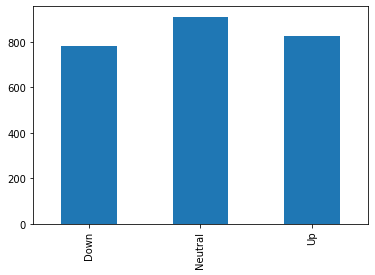

In [27]:
# Takes 2 mins to run
for m in models:
    add_to_features_df(m,dataset='Original')
    add_metrics(model=m,dataset='Original',X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test,set='combined')
    
# Shapes
get_shapes(dataset = 'Original')

### ***Functions to plot Blocked TimeSeries Split****

In [ ]:

n_splits = 5
cv = BlockingTimeSeriesSplit
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

print("The horizontal axis is the training set size while the vertical axis represents the cross-validation iterations. The folds used for training are depicted in blue and the folds used for validation are depicted in orange. The final horizontal bar are the FIVE [-2,-1,0,1,2] class labels for the response variable")
plot_timeseries_split(np.array(X_train_dict['Original']),np.array(y_train.Labels),n_splits,cmap_cv,cmap_data,cv)


### Remove all constant Variables
<div style="color: Green; font-size:22px;" class="alert alert-block alert-warning"> 
<b>To Do:</b> Check why the following features have only one value
</div>

In [ ]:
# Issue with using XGBOOST - takes long time and gives warnigs Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
# Takes 4 minutes to run

warnings.filterwarnings("ignore")

dataset = 'Constant_weighted'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=1, variables=None, missing_values='raise'))])

                     
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None,sampled_weights=True, transform = True)
apply_model_transform(dataset,'Original', pipe, models[1],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None,sampled_weights=True, transform = True)

dataset = 'Constant'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=1, variables=None, missing_values='raise'))])

apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None, sampled_weights=False, transform = True)
# apply_model_transform(dataset,'Original', pipe, models[1],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None, sampled_weights=False, transform = True)



### Build 1 Model with 1 Feature only

**Check Kappa Score for both these models - one with sampled weights and other without**

In [ ]:
original_dataset = 'Original'
dataset = 'Spread_1-2'
model = models[0]
feats_to_keep_list = ['LumberContractSpreads FirstSecond']
# insert_model_stats(dataset,original_dataset, feats_to_keep_list, model, set='combined')
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = feats_to_keep_list, sampled_weights=True, transform = False)


In [ ]:
original_dataset = 'Original'
dataset = 'Spread_1-2_No_weights'
model = models[0]
feats_to_keep_list = ['LumberContractSpreads FirstSecond']
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = feats_to_keep_list, sampled_weights=False, transform = False)

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2')]

### Remove Quasi-constant features

In [ ]:
dataset = 'QuasiConstant'
pipe = Pipeline([(dataset, DropConstantFeatures(tol=0.95, variables=None, missing_values='raise'))])
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None, sampled_weights=True, transform = True)

### Remove Duplicated Features

In [ ]:
dataset = 'Duplicated'
pipe = Pipeline([(dataset, DropDuplicateFeatures(variables=None, missing_values='raise')),])
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined', sampled_weights=True, transform = True)

### Remove Duplicated & Quasi Constant Features

In [ ]:
dataset = 'Dupl&QConstant'
pipe = Pipeline([(dataset, DropDuplicateFeatures(variables=None, missing_values='raise')),])
apply_model_transform(dataset,'QuasiConstant', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = None, sampled_weights=True, transform = True)


### Remove Correlated Features

In [ ]:
warnings.filterwarnings("ignore")

smart_correlation_estimator = models[0]
dataset = 'Correlated'
pipe = Pipeline([(dataset, SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test,set='combined', sampled_weights=True, transform = True)

### Remove Duplicated, Quasi Constant & Correlated Features

In [ ]:
warnings.filterwarnings("ignore")
smart_correlation_estimator = models[0]
dataset = 'Clean'
pipe = Pipeline([(dataset, SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_model_transform(dataset,'Dupl&QConstant', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list=None, sampled_weights=True, transform = True)


### Clean1 - Drop constant, quasi Constant, duplicated and correlated features

In [ ]:
# Takes 2 minutes to run
warnings.filterwarnings("ignore")

smart_correlation_estimator = models[0]
dataset = 'Clean1'
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.95, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=smart_correlation_estimator,scoring="roc_auc",cv=btscv,)),])
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict,X_test_dict,y_train,y_test, set='combined',manual_list=None, sampled_weights=True, transform = True)

apply_model_transform(dataset,'Original', pipe, models[1],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list=None, sampled_weights=False, transform = True)


In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1).loc[('RandomForestClassifier','Spread_1-2_No_weights')]

**

In [ ]:
features_df.index

In [ ]:
'f1_weighted', 'neg_log_loss', 'cohen_kappa_score', 'precision_weighted','roc_auc_ovr_weighted'

In [ ]:
features_df.sort_values(by=['pnl','f1_weighted','recall_weighted','precision_weighted'],ascending=False, inplace=True)

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

## Manual Feature Selection

To Do

**Engineered**
1. LB_High - LB_Low
2. Get Other Basis
3. Use some techincal Indicators

**Raw**
1. LB_Volume	
2. LB_openInterest



### Read List

In [ ]:
# pd.Series(Variables.columns.tolist()).to_csv('Variable_columns_names.csv',index=False)

manual_list = pd.read_excel('C:/source/2x4-data/app/model_building/ManualSelectList.xlsx',sheet_name='Variables', index_col=0)
manual_list = manual_list[manual_list.index == 1]
manual_list = manual_list.values.tolist()
manual_list = [x for xs in manual_list for x in xs]

In [ ]:
warnings.filterwarnings("ignore")

original_dataset='Original'

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.90, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=model,scoring="precision_weighted",cv=btscv,)),])

dataset='ManualSelection_Weighted_Transformed'
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = manual_list, sampled_weights=True, transform = True)

dataset='ManualSelection'
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = manual_list, sampled_weights=False, transform = False)

dataset='ManualSelection_Transformed'
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = manual_list, transform = True)


In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
pd.DataFrame(features_df.drop(['Model_Details','Removed_Features','ClassDf'],axis=1).loc[('RandomForestClassifier','ManualSelection_Transformed')]['Features_List']).to_csv('C:/source/2x4-data/app/model_building/delete.csv',index=False)

In [ ]:
dataset='ManualSelection_Try_1'
apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict,X_test_dict,y_train,y_test, set='combined',manual_list = manual_list, sampled_weights=False, transform = True)


In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1).loc[('RandomForestClassifier','ManualSelection_Weighted_Transformed')]['ClassDf'][0]

### Mutual Information BY COHORT & Total

In [ ]:
dataset = 'Original'
X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
X.columns = Variables_midx.columns
train_idx  = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['test']
X_train = X.iloc[train_idx]
y_train1 = y.iloc[train_idx]


top_cohort_variable = pd.DataFrame(index = Variables_midx.columns.get_level_values(0).unique(), columns=['Variable','Score','Col_name'])
for outer_col in Variables_midx.columns.get_level_values(0).unique():
    
    sel_  = SelectKBest(mutual_info_classif, k=1).fit(X_train.loc[:,(outer_col,)], y_train1.Labels)
    
    selected_col = [x for x,y in zip(pd.DataFrame(X_train.loc[:,(outer_col,)]).columns,sel_.get_support()) if y]
    # col_name = tuple(outer_col+','+selected_col[0])

    selected_col_score = [x for x,y in zip(sel_.scores_,sel_.get_support()) if y]
    # top_cohort_variable[outer_col] = [selected_col[0],selected_col_score[0]]
    # cols = pd.MultiIndex.from_product([[outer_col], (selected_col[0])])
    top_cohort_variable.loc[outer_col,'Variable'] = selected_col[0]
    top_cohort_variable.loc[outer_col,'Score'] = selected_col_score[0]

    try:
        top_cohort_variable.loc[outer_col,'Col_name'] = outer_col+" "+selected_col[0]
    except:
        print(outer_col, selected_col[0])

    # inner_cols = [x for x in pd.DataFrame(X_train.loc[:,(outer_col,)]).columns]    
    # print(sel_.scores_)
    # print(sel_.get_support())
    # print(outer_col,selected_col[0])
    # print(selected_col_score)
    # print(top_cohort_variable[outer_col])
    # print('\n')

    # TA_df.columns = [('TA_',x) for x in TA_df.columns]
    
# Make column names same as Variables
for col in top_cohort_variable.Col_name:
    top_cohort_variable.loc[top_cohort_variable['Col_name'] == col, 'Col_name'] = str(col).translate(str.maketrans('', '', string.punctuation)).lstrip().rstrip()


# Keeping only top 95% percentile of variables in terms of mutual info score - Enter 1- percentile value in the below line
top_cohort_variable = top_cohort_variable[top_cohort_variable.Score > top_cohort_variable.Score.quantile(.05)]

top_cohort_variable.sort_values(by=['Score'],ascending=False, inplace=True)

top_cohort_variable.plot(x='Variable',y='Score',kind='bar', figsize=(20,10));


In [ ]:


warnings.filterwarnings("ignore")
base_estimator = RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False)
model = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, max_features=1.0)
dataset='Top_K_Cohort_MI_Weighted_Transformed_50%PERCENTILE'

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.90, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=model,scoring="precision_weighted",cv=btscv,)),])

apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = top_cohort_variable.Col_name.values.tolist(), sampled_weights=True, transform = True)


In [ ]:
# pd.DataFrame(features_df.drop(['Model_Details','Removed_Features','ClassDf'],axis=1).loc[('RandomForestClassifier','Top_K_Cohort_MI_Weighted_Transformed_50%PERCENTILE')]['Features_List']).to_csv('Top_variable.csv')

In [ ]:
# top_cohort_variable['Col_name'].to_csv('top_cohort_variable.csv')

### FEATURE IMPORTANCE BY COHORT

In [ ]:
dataset = 'Original'
X, y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
X.columns = Variables_midx.columns
train_idx  = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits= 5, flatten = True)['test']
X_train = X.iloc[train_idx]
y_train1 = y.iloc[train_idx]


top_cohort_variable = pd.DataFrame(index = Variables_midx.columns.get_level_values(0).unique(), columns=['Variable','Score','Col_name'])
for outer_col in Variables_midx.columns.get_level_values(0).unique():
    

    sel_ = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=10))

    sel_.fit(X_train.loc[:,(outer_col,)], y_train1.Labels)

    
    sel_  = SelectKBest(mutual_info_classif, k=1).fit(X_train.loc[:,(outer_col,)], y_train1.Labels)
    
    selected_col = [x for x,y in zip(pd.DataFrame(X_train.loc[:,(outer_col,)]).columns,sel_.get_support()) if y]
    # col_name = tuple(outer_col+','+selected_col[0])

    selected_col_score = [x for x,y in zip(sel_.scores_,sel_.get_support()) if y]
    # top_cohort_variable[outer_col] = [selected_col[0],selected_col_score[0]]
    # cols = pd.MultiIndex.from_product([[outer_col], (selected_col[0])])
    top_cohort_variable.loc[outer_col,'Variable'] = selected_col[0]
    top_cohort_variable.loc[outer_col,'Score'] = selected_col_score[0]

    try:
        top_cohort_variable.loc[outer_col,'Col_name'] = outer_col+" "+selected_col[0]
    except:
        print(outer_col, selected_col[0])

    # inner_cols = [x for x in pd.DataFrame(X_train.loc[:,(outer_col,)]).columns]    
    # print(sel_.scores_)
    # print(sel_.get_support())
    # print(outer_col,selected_col[0])
    # print(selected_col_score)
    # print(top_cohort_variable[outer_col])
    # print('\n')

    # TA_df.columns = [('TA_',x) for x in TA_df.columns]
    
# Make column names same as Variables
for col in top_cohort_variable.Col_name:
    top_cohort_variable.loc[top_cohort_variable['Col_name'] == col, 'Col_name'] = str(col).translate(str.maketrans('', '', string.punctuation)).lstrip().rstrip()


# Keeping only top 95% percentile of variables in terms of mutual info score - Enter 1- percentile value in the below line
top_cohort_variable = top_cohort_variable[top_cohort_variable.Score > top_cohort_variable.Score.quantile(.5)] #0.05

top_cohort_variable.sort_values(by=['Score'],ascending=False, inplace=True)

top_cohort_variable.plot(x='Variable',y='Score',kind='bar', figsize=(20,10));


In [ ]:
top_cohort_variable['Col_name'].to_csv('top_cohort_variable.csv')

In [ ]:
len(top_cohort_variable)

In [ ]:
models[0]

In [ ]:
warnings.filterwarnings("ignore")

model = models[1]
dataset='Top_K_Cohort_FeatImp_Weighted_Transformed_50%PERCENTILE'

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.95,missing_values="raise",selection_method="variance",estimator=model,scoring="f1_weighted",cv=btscv,)),])

apply_model_transform(dataset,'Original', pipe, models[0],X_train_dict=X_train_dict,X_test_dict=X_test_dict,y_train=y_train,y_test=y_test, set='combined',manual_list = top_cohort_variable.Col_name.values.tolist(), sampled_weights=True, transform = True)


In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

### Splitting the Dataset in 3 Dictionaries of Training, Testing & Validation & Initiating features_df

###### Note: If metric calculations in add_metric function is calculated on Data which has even one class missing from y_predictions, it will throw an error (when error='raise' used), or it will be NaN for (roc_auc_ovr_weighted & roc_auc_ovo_weighted) if this option is not used in cross_val_score..


In [ ]:
STOP HERE


In [ ]:
sel_  = SelectKBest(mutual_info_classif, k=20).fit(X_train, y_train1.Labels)
X_train.columns[sel_.get_support()]

In [ ]:
# determine the mutual information

# mi = mutual_info_classif(X_train, y_train1.Labels)
# mi = pd.Series(mi)
# mi.index = X_train.columns
# mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
# plt.ylabel('Mutual Information')

t = SelectKBest(mutual_info_classif).fit(X_train, y_train1.Labels)
t

In [ ]:
t.scores_.tolist()

In [ ]:
# pd.DataFrame(data = [t.scores_.tolist(),X_train.columns], columns = ['Score','Selected']).sort_values(by=['Score'],ascending=False)

**yellowbricks**

In [ ]:
dataset = 'ManualSelection'
X,y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
train_idx =  get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits, flatten=True)['train']
test_idx = get_cv_indices(BlockingTimeSeriesSplit, X, y, n_splits, flatten=True)['test']
X_train  = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

from yellowbrick.classifier import (ClassificationReport,  DiscriminationThreshold,)
rf = RandomForestClassifier(max_depth=4, n_estimators=20, n_jobs=-1)
visualizer = ClassificationReport(rf, support=True)

visualizer.fit(X_train, y_train.Labels)        # Fit the visualizer and the model
visualizer.score(X_test , y_test.Labels)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [ ]:
dataset = 'ManualSelection'
X,y = get_x_y_sets(dataset,X_train_dict,X_test_dict,y_train,y_test, set='combined')
rf = RandomForestClassifier(max_depth=4, n_estimators=20, n_jobs=-1)
original, predicted = predictions_from_custom_cross_val(rf,X, y, custom_cv = BlockingTimeSeriesSplit(n_splits=5), sampled_weights=True)
# cm = pd.DataFrame(confusion_matrix(original, predicted), index=Response['Labels'].unique(), columns=Response['Labels'].unique())

In [ ]:
len(X), len(y)

In [ ]:
len(X_train_dict['ManualSelection']), len(y_train)

In [ ]:

model = LogisticRegression(multi_class="auto", solver="liblinear")

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(model, classes=[-1,-0,1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1).loc[('RandomForestClassifier','ManualSelection')]['ClassDf'][0]

### Save Below

In [ ]:
X = pd.concat([X_train_dict['Original'],X_test_dict['Original']],axis=0)
y = pd.concat([y_train,y_test],axis=0)
model = models[0]

In [ ]:
com1_original, com1_predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=False)
com2_original, com2_predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv, sampled_weights=True)
com1_original == com2_original, com1_predicted == com2_predicted


In [ ]:

pd.DataFrame(data = [pd.Series(com1_predicted).value_counts().sort_index(), pd.Series(com1_original).value_counts().sort_index()], index = ['predicted','original']).T



In [ ]:
pd.DataFrame(data = [pd.Series(com2_predicted).value_counts().sort_index(), pd.Series(com2_original).value_counts().sort_index()], index = ['predicted','original']).T


In [ ]:
# class_weight='balanced'



In [ ]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
class_weights = compute_class_weight(class_weight = "balanced",classes= lab, y = y.Labels)
computed_sample_weights = compute_sample_weight('balanced', y.Labels)
class_weights

In [ ]:
computed_sample_weights

In [ ]:
group_df = pd.DataFrame(data = [computed_sample_weights, y.Labels], index = ['computed_sample_weights','Labels']).T
group_df
group_df.groupby('Labels').mean()

In [ ]:
Response[['Labels','sample_weights']].groupby('Labels').sum()
# Response[['Labels','sample_weights']].groupby('Labels').mean()


In [ ]:

create_bins_data(Response,'sample_weights',10)

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
features_df.loc[('RandomForestClassifier','ManualSelection')]['ClassDf'][0]

In [ ]:
features_df.loc[('RandomForestClassifier','Clean1')]['ClassDf'][0]

In [ ]:
feats_to_keep_list = ['LumberContractSpreads FirstSecond','lumbermovingaverages MA200']

In [ ]:
original_dataset = 'Original'
dataset = 'Spread_1-2_wts'
model = models[0]
feats_to_keep_list = ['LumberContractSpreads FirstSecond','lumbermovingaverages MA200']
# insert_model_stats(dataset,original_dataset, feats_to_keep_list, model, set='combined', sampled_weights= True)


In [ ]:
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index() 


original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv)
cm = pd.DataFrame(confusion_matrix(original, predicted), index=lab, columns=lab)
all_class_metric = metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1)

In [ ]:
cm

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2_wts')]['ClassDf'][0]

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2')]['ClassDf'][0]

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2_MA200')]['ClassDf'][0]


In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2')]

In [ ]:
features_df.loc[('RandomForestClassifier','Spread_1-2_MA200')]


In [ ]:
X_train_dict[dataset].iloc[:, : 8]

In [ ]:
# 'log_loss'


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(model, 
           k_features=6, # the more features we want, the longer it will take to run
           forward=True, 
           floating=True, # see the docs for more details in this parameter
           verbose=2, # this indicates how much to print out intermediate steps
           scoring='f1_weighted', 
           cv=btscv,
           n_jobs=-1,
            
         )

weights = np.abs(y.Adj_ret_2.values)

sfs = sfs.fit(X, y.Labels,sample_weight=weights)

In [ ]:
df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
df.sort_values('avg_score', inplace=True, ascending=False)
df

In [ ]:
#### TEST 
dataset = 'Original'
X = X_train_dict[dataset].sort_index()
y = y_train.sort_index() 

model = RandomForestClassifier(n_estimators=1, max_depth=1, n_jobs=-1)
  

efs1 = EFS(model, 
           min_features=1,
           max_features=1,
           scoring='f1',
           print_progress=True,
           cv=btscv)

efs1 = efs1.fit(X, y.Labels)



In [ ]:
print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

In [ ]:
dataset = 'Clean1'
model = RandomForestClassifier(n_estimators=5, max_depth=2, n_jobs=-1)
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index()    

efs1 = EFS(model, 
           min_features=1,
           max_features=2,
           scoring='f1',
           print_progress=True,
           cv=btscv)

efs1 = efs1.fit(X, y.Labels)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)



In [ ]:
efs1.subsets_

In [ ]:
df = pd.DataFrame.from_dict(efs1.get_metric_dict()).T
df.sort_values('avg_score', inplace=True, ascending=False)
df

In [ ]:
STOP HERE 

In [ ]:
model = models[0]
model.fit(X_train_dict['Clean1'], y_train.Labels)
plot_confusion_matrix(model, X_test_dict['Clean1'], y_test.Labels)

In [ ]:
# Fitting the model here since it takes > 1 min
xgb = XGBClassifier(n_estimators=200, max_depth=3, n_jobs=-1,eval_metric='mlogloss')
xgb.fit(X_train_dict['Clean1'], y_train.Labels)

In [ ]:

y_pred = xgb.predict(X_test_dict['Clean1'])
df1 = pd.DataFrame(np.transpose(precision_recall_fscore_support(y_test.Labels, y_pred, average=None)),columns=['precision', 'recall', 'fscore', 'support'], index=lab)
df1




In [ ]:

from sklearn.model_selection import cross_val_predict

model = models[0]
model.fit(X_train_dict['Clean1'], y_train.Labels)
y_pred = model.predict(X_test_dict['Clean1'])

# y_pred = cross_val_score(model, X_train_dict['Clean1'], y_train.Labels, cv=5)
# y_pred


In [ ]:
y_pred.shape

In [ ]:
y_train.Labels.shape

In [ ]:
# Fitting the model here since takes ~ 1.30 minute
# model = models[1]
# model.fit(X_train_dict['Clean1'], y_train.Labels)
# y_pred = model.predict(X_test_dict['Clean1'])

In [ ]:


model = models[0]

X = X_test_dict['Clean1'].sort_index()
y = y_test.sort_index()  

original, predicted = predictions_from_custom_cross_val(model,X, y, custom_cv = btscv)

cm = pd.DataFrame(confusion_matrix(original, predicted), index=lab, columns=lab)
cm


In [ ]:
280/1386

In [ ]:
len(original), y_test.Labels.shape, len(predicted)

In [ ]:
all_class_metric = metrics_from_cm(cm, lab = sorted(Response['Labels'].unique()))
all_class_metric


In [ ]:
print(classification_report(original, predicted)) 

In [ ]:
# features_df.drop(['Model_Details','Features_List','Removed_Features'],axis=1)

In [ ]:
precision_recall_fscore_support(original, predicted, average='weighted')

In [ ]:
print(classification_report(y_test.Labels, y_pred))

In [ ]:
# Insert the dataframe in a cell in features_df
# features_df['to_delete'] = None
# features_df['to_delete'].astype(object)
# features_df.loc[('RandomForestClassifier','Original'),'to_delete'] =  [all_class_metric]

In [ ]:
# features_df.loc[('RandomForestClassifier','Original'),'to_delete'][0]

### Cross Entropy - Negative Log Liklehood or Log Loss - Custom Function Implementation

In [ ]:
# Lower The Better

model = models[0]
model.fit(X_train_dict['Original'], y_train.Labels)
y_prob = model.predict_proba(X_test_dict['Original'])

# This line required to convert for custom implementation from normal labels to indexed labels
y_actuals = y_test.Labels.replace(to_replace=sorted(y_test.Labels.unique()), value=list(range(len(y_test.Labels.unique())))).values

# Custom function to compute negative log loss
nll = np.mean([-np.log(y_prob[i,j]) for i,j in zip(range(y_prob.shape[0]),y_actuals)])
print(nll) 

In [ ]:
features_df.drop(['Model_Details','Features_List','Removed_Features','ClassDf'],axis=1).loc[('RandomForestClassifier',)]

In [ ]:
print(log_loss(y_actuals, y_prob))
print(log_loss(y_test.Labels, y_prob))

In [ ]:
from sklearn.metrics import log_loss

model = models[0]
dataset = 'Clean'
X = pd.concat([X_train_dict[dataset],X_test_dict[dataset]]).sort_index()
y = pd.concat([y_train,y_test]).sort_index() 

LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
scores = cross_val_score(model, X, y.Labels, cv=btscv, scoring=LogLoss)
scores.mean()

In [ ]:
LogLoss._select_proba_binary(predicted,y_test.Labels.values) 

In [ ]:

probabilities_from_custom_cross_val(model,X, y, custom_cv = btscv)

In [ ]:
from sklearn.model_selection import cross_val_predict

# proba = cross_val_predict(model, X, y, cv=btscv, method='predict_proba')

In [ ]:
STOP HERE

****TO USE***

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])

y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)


model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

### Univariate Selection Methods - Mostly just examine linear relationships

#### Mutual Information

In [ ]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)

# Plot
# mi.plot.bar(figsize=(20, 6))
# plt.ylabel('Mutual Information')

# select features
sel_ = SelectKBest(mutual_info_classif, k=15).fit(X_train, y_train)

# display features
X_train.columns[sel_.get_support()]

#### Chi-square Statistic - only suited for classification!                                         
https://www.udemy.com/course/feature-selection-for-machine-learning/learn/lecture/22495182#questions
https://github.com/solegalli/feature-selection-for-machine-learning/blob/main/05-Filter-Statistical-Tests/05.2-Fisher-score.ipynb

In [ ]:
# calculate the chi2 p_value between each of the variables and the target
# chi2 returns 2 arrays, one contains the F-Scores which are then evaluated against the chi2 distribution to obtain the pvalue. The pvalues are in the second array

# Input X must be non-negative
X_train_non_negative = X_train[X_train.columns[((X_train < 0).sum(axis=0) == 0).values]]
f_score = chi2(X_train_non_negative.fillna(0), y_train)
pvalues = pd.Series(f_score[1])
pvalues.index = X_train_non_negative.columns
pvalues.sort_values(ascending=True, inplace = True)
extremely_low_p_values = len(pvalues[pvalues < 1e-100])
sel_ = SelectKBest(chi2, k= extremely_low_p_values).fit(X_train_non_negative, y_train)
X_train_non_negative.columns[sel_.get_support()] # display features

# X_train = sel_.transform(X_train)
# X_test = sel_.transform(X_test)

#### Anova - tests 2 samples have same mean

Assumptions:
Sample are independant & normally distributed, homegeneity of variance

In [ ]:
# calculate the univariate statistical measure between each of the variables and the target
# similarly to chi2, the output is one array with f-scores and one array with the pvalues

univariate = f_classif(X_train, y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=True, inplace = True) # The smaller the p_value the more predictive the feature is

pvalue_above_5_percent = len(univariate[univariate < 0.05])
sel_ = SelectKBest(f_classif, k=pvalue_above_5_percent).fit(X_train, y_train)
features_to_keep = sel_.get_feature_names_out()
features_to_keep

# select features
# X_train_anova = sel_.transform(X_train)
# X_test_anova = sel_.transform(X_test)

# # numpy array to dataframe
# X_train_anova = pd.DataFrame(X_train_anova)
# X_train_anova.columns = features_to_keep

# X_test_anova = pd.DataFrame(X_test_anova)
# X_test_anova.columns = features_to_keep

# X_train_anova.shape, X_test_anova.shape



### Wrapper Methods

### Embedded Methods | Tree Importance

In [ ]:
# Selects features whose importance is greater than the threshold. - Thershold is the mean importance of all features
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
TopNFeatures = pd.DataFrame(index = sel_.estimator_.feature_names_in_.tolist(),data = sel_.estimator_.feature_importances_, columns = ['Imp']).sort_values(by='Imp',ascending=False).head(20).index.tolist()
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20);

In [ ]:
TopNFeatures

### Embedded Methods | Tree Importance Recursively

In [ ]:
# Takes 1:44 mins to run
sel_ = RFE(RandomForestClassifier(n_estimators=100,  max_depth=3, n_jobs=-1), n_features_to_select=30).fit(X_train, y_train)
selected_features = X_train.columns[sel_.get_support()]
print(len(selected_features))
selected_features


In [ ]:
rf = RandomForestClassifier(n_estimators=200, max_depth=3, n_jobs=-1)
rf.fit(X_train[selected_features].fillna(0), y_train)
y_pred = rf.predict(X_test[selected_features].fillna(0))
y_valid_pred = rf.predict(X_val[selected_features].fillna(0))
print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val.fillna(0), y_valid_pred))


In [ ]:
print('Train set')
pred = rf.predict_proba(X_train[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

print('Test set')
pred = rf.predict_proba(X_test[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

print('Validation set')
pred = rf.predict_proba(X_val[selected_features])
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_val, pred[:, 1])))

### Feature Selection by Random Shuffling

In [ ]:
# Takes 1 min to run - You can use this procedure with any machine learning algorithm

rf = RandomForestClassifier(n_estimators=50, max_depth=2, n_jobs=-1)

sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=rf, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=btscv, # cross validation
)

sel.fit(X_train, y_train)


In [ ]:
sel.initial_model_performance_ # performance of model trained with all features

In [ ]:
# pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(16,6));

In [ ]:
# features that will be removed

print(len(sel.features_to_drop_))
# remove features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
X_val = sel.transform(X_val)

X_train.shape, X_test.shape

In [ ]:
rf.fit(X_train, y_train)
print( 'train auc score: ',roc_auc_score(y_train, (rf.predict_proba(X_train))[:,1]))
print('test auc score: ', roc_auc_score(y_test, (rf.predict_proba(X_test))[:, 1]))
print('Validation auc score: ', roc_auc_score(y_val, (rf.predict_proba(X_val))[:, 1]))

In [ ]:
X_train.columns

### Recursive Feature Elimination

In [ ]:
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

In [ ]:
# NOT WORKING

sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = 'roc_auc', # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=btscv, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
# sel.fit(X_train, y_train)

In [ ]:
sel.initial_model_performance_

In [ ]:
# performance of model trained using all features
sel.initial_model_performance_

In [ ]:
# importance of all features based of initial model
sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [ ]:
# Number of features that will be removed

len(sel.features_to_drop_)

### Random Forest

In [ ]:
features = list(X_train.columns)
rf = RandomForestClassifier(n_estimators=200, max_depth=3)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
importance.sort_values(by=['importance'], ascending=False, inplace=True)
y_pred = rf.predict(X_test[features].fillna(0))
y_valid_pred = rf.predict(X_val[features].fillna(0))

print("Test Accuracy:", accuracy_score(y_test.fillna(0), y_pred))
print("Validation Accuracy:", accuracy_score(y_val .fillna(0), y_valid_pred))

### Compare the performance in machine learning algorithms

In [ ]:
X_train_basic_filter.shape, X_test_basic_filter.shape, X_train.shape, X_test.shape

In [ ]:

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=300,  max_depth=3, n_jobs=-1)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [ ]:
# filter methods - basic
run_randomForests(X_train_basic_filter,X_test_basic_filter,y_train, y_test)

In [ ]:
# Final model
run_randomForests(X_train, X_test, y_train, y_test)

### Logistic Regression

In [ ]:
# create a function to build logistic regression and compare performance in train and test set

from sklearn.metrics import confusion_matrix

def run_logistic(X_train, X_test, y_train, y_test):
    
    # function to train and test the performance of logistic regression
    logit = LogisticRegression(penalty='l1', random_state=44, max_iter=1000, solver='liblinear')
    logit.fit(X_train, y_train)
    print('Train set')
    pred = logit.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    print('Test set')
    pred = logit.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

scaler = StandardScaler().fit(X_train)

run_logistic(scaler.transform(X_train),
             scaler.transform(X_test),
                  y_train, y_test)

### 
<div style="color: DarkBlue; font-size:22px;" class="alert alert-block alert-warning"> 
<b>Pipelines:</b> Final Code will look like this but for now work through issues above 
</div>

In [ ]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasiConstant', DropConstantFeatures(tol=0.9, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures(variables=None, missing_values='raise')),
    ('correlation', SmartCorrelatedSelection(variables=None, method="spearman",threshold=0.9,missing_values="raise",selection_method="variance",estimator=rf,scoring="roc_auc",cv=btscv,)),])


pipe.fit(X_train)

# remove features
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
X_val = pipe.transform(X_val)

X_train.shape, X_test.shape, X_val.shape


In [ ]:
print(len(pipe.named_steps['constant'].features_to_drop_))
pipe.named_steps['duplicated'].features_to_drop_

# NOT USING - for reference

### Correlated Features - Brute Force approach

In [ ]:
def correlation(dataset, threshold):
    
    col_corr = set()
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        
        for j in range(i):
            
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
             
                print(abs(corr_matrix.iloc[i, j]),":", corr_matrix.columns[i], "<< - >>", corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

# corr_features = correlation(X_train, 0.9)
# len(set(corr_features))


In [ ]:
# corr_features = correlation(X_train, 0.9)

### Correlated Features - Second Approach

In [ ]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.9]
corrmat = corrmat[corrmat < 1] # Not Interested in the correlation with 1 since will be with the same variable
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

In [ ]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))



In [ ]:
# for group in correlated_groups:
#     print(group)
#     print()

In [ ]:
#Choose Group Index
group_index = 1

group = correlated_groups[group_index]
var = group.feature1.unique()[0]

# add all features of the group to a list
features = list(group['feature2'].unique())+[var]

rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

importance = pd.concat([pd.Series(features),pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']

print(var)
importance.sort_values(by='importance', ascending=False)


In [ ]:
# for feature in group['feature2']:
#     plt.scatter(X_train[var], X_train[feature])
#     plt.xlabel(feature)
#     plt.ylabel(var)
#     plt.show()

### Just an example to show one group of how smart correlation works

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

group = sel.correlated_feature_sets_[0]

# build random forest with cross validation for each feature
for f in group:
    
    model = cross_validate(
        rf,
        X_train[f].to_frame(),
        y_train,
        cv=btscv,
        return_estimator=False,
        scoring='accuracy',
    )

#  scoring='roc_auc' does not support categorical data.

    print(f, model["test_score"].mean())

****TO USE***

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])

y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)


model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

### Classification Model Evaluation metrics
1. cross_val_score
2. Area under the ROC Curve
3. Confusion Matrix
4. Confusion Report

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics


In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
cross_val_score(model, Variables, Response.Close_Up_Down, cv = 2, scoring = 'accuracy')

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
cross_val_score(model, X_train_dict['Original'], y_train.Labels, cv = 5,scoring='roc_auc_ovo_weighted')

In [ ]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
cross_val_score(model, X_train_dict['Clean1'], y_train.Labels, cv = 5,scoring='roc_auc_ovo')

In [ ]:
model.fit(X_train_dict['Original'], y_train.Close_Up_Down)
y_prob = model.predict_proba(X_test_dict['Original'])
y_pred = model.predict(X_test_dict['Original'])


In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
clf.fit(X_train_dict['Original'], y_train.Close_Up_Down)

for p in [0.475,0.5,0.525]:
    
    y_pred = (clf.predict_proba(X_test_dict['Original'])[:,1] >= p).astype(bool) # set threshold as 0.3
    fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_pred,)
    print("tpr:",tpr)
    print("fpr:",fpr)
    print("threshold:",threshold)
    print(p,": ",roc_auc_score(y_test.Close_Up_Down, y_pred))
    print("\n")

https://stackoverflow.com/questions/45715018/scikit-learn-how-to-plot-probabilities

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
clf.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
plt.figure(figsize=(12,5))
prediction = clf.predict_proba(X_test_dict['Clean'])[:,1]
plt.hist(prediction[y_test.Close_Up_Down==-1], bins=100, label='Negatives')
plt.hist(prediction[y_test.Close_Up_Down==1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=10)
plt.ylabel('Number of records in each bucket', fontsize=10)
# plt.xlim(0,1)
plt.legend(fontsize=10)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

In [ ]:
def plot_roc_auc_curve(y_test, model_set, model):
    model.fit(X_train_dict[model_set], y_train.Close_Up_Down)
    y_prob_positive = model.predict_proba(X_test_dict[model_set])[:,1]
    print(f"ROC_AUC_SCORE: {roc_auc_score(y_test.Close_Up_Down, y_prob_positive):.2f}%")
    fpr, tpr, threshold = roc_curve(y_test.Close_Up_Down, y_prob_positive,)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)

plot_roc_auc_curve(y_test, 'Original', model)
# plot_roc_auc_curve(y_test, 'Original', y_test)

In [ ]:
(y_pred == [-1 if x[0] > 0.5 else 1 for x in y_prob]).all()

In [ ]:
# Took 5:20 mins
# from sklearn.ensemble import GradientBoostingClassifier
# model = GradientBoostingClassifier(n_estimators=100, max_depth=3)
# cross_val_score(model, Variables, Response.Close_Up_Down, cv = 5).min()

**Confusion Matrix**

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
model.fit(X_train_dict['Clean'], y_train.Close_Up_Down)
y_pred = model.predict(X_test_dict['Clean'])
confusion_matrix(y_test.Close_Up_Down, y_pred)

In [ ]:
pd.crosstab(y_test.Close_Up_Down, y_pred, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(y_test.Close_Up_Down, y_pred)
sns.heatmap(pd.crosstab(y_test.Close_Up_Down, y_pred, rownames=['Actual'], colnames=['Predicted']), annot=True)

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(8,5))

ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues');
plt.xlabel('Actual');
plt.ylabel('Predicted');




In [ ]:
plot_confusion_matrix(clf, X_test_dict['Clean'], y_test.Close_Up_Down,);

In [ ]:
plot_confusion_matrix(clf, X_val_dict['Clean'], y_val.Close_Up_Down,);

**Clasification Report**

In [ ]:
clsf_report = classification_report(y_test.Close_Up_Down, y_pred, output_dict=True)
pd.DataFrame(clsf_report)

In [ ]:
fpr

In [ ]:
print(classification_report(y_test.Close_Up_Down, y_pred))

In [ ]:
clsf_report['-1.0']['f1-score']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, det_curve
precision_score(y_test.Close_Up_Down, y_pred)

In [ ]:
fpr_, fnr_, thresholds_ = det_curve(y_test.Close_Up_Down, y_pred)

In [ ]:
fpr_

In [ ]:
fnr_

In [ ]:
thresholds_